__Group 20__:
- __Inês Rocha 20220052@novaims.unl.pt__
- __Pedro Ferreira 20220589@novaims.unl.pt__
- __Quintino Fernandes 20220634@novaims.unl.pt__

__Dataset__: https://drive.google.com/drive/folders/1NJOCRQ3ynA4BEOvWj5Ypr6iwi108LfOh?usp=share_link

(This is the non-zipped version, so one can see the images themselves. For the notebook, we use a zipped version, whose link is in the cell where the folder is imported. This is the dataset that we import to the model notebook, so it already has transformations that are made in preprocessing).

__Summary of the notebook:__

In this notebook we do some preprocessing to our data:

- First of all, we apply a noise reduction algorithm from the cv2 library to remove the hairs that might be in front of the skin mark;

- We define our oversampling technique, which is very basic and consists of copying images from the minority classes so the number of instances in each train class is very similar. Note that we only define this, because the function will be present inside the model dataset, as it allows us to have more control over it and allows us to change the number of copies there, if we wanted to;

- We define our data augmentation pipeline as well. We only define it, because it will be put inside some models, because we want to try some with and some withouot it. Just like the copies function, the Sequential model that does the data augmentation will be defined inside the next notebook and particularl inside a model where we want to try it with.

__The problem__: We have a dataset with around 10000 photo images of skin marks in humans. They are all labeled as a type of cancer, so our objective is to train a neural network and improve it to the point where it can distinguish from the various types of cancer, as accurately as it can. To do so, we will try some variations of a particular neural network architecture (the residual neural network), changing some things to try to adapt a neural network to our specific problem.

__References__: 
__References:__
1. [Algorithms for Skin Cancer Classification from Dermoscopic Images (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8945332/)
2. [Skin Cancer Classification from Dermoscopic Images: A Systematic Review (2022)](https://www.mdpi.com/1999-4893/15/11/438)
3. [Skin Cancer Classification: A Systematic Review (2022)](https://www.frontiersin.org/articles/10.3389/fonc.2022.893972/full)
4. [KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)
5. [OpenCV Morphological Operations (2021), by Adrian Rosebrock](https://pyimagesearch.com/2021/04/28/opencv-morphological-operations/)
6. [OpenCV Thresholding (2021), by Adrian Rosebrock](https://pyimagesearch.com/2021/04/28/opencv-thresholding-cv2-threshold/)
7. [Digital Hair Removal](https://github.com/sunnyshah2894/DigitalHairRemoval)
8. [Image Inpainting](https://docs.opencv.org/3.4/df/d3d/tutorial_py_inpainting.html)
9. [Image Inpainting using OpenCV (2023)](https://www.geeksforgeeks.org/image-inpainting-using-opencv/)
10. [Classification on imbalanced data, official documentation](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=pt-br)


# 1. Import the dataset

We begin by installing and importing the necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 

import os
import shutil
import random 
import zipfile
import cv2

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow

import gdown

We upload the zip file with our Skin Cancer dataset

In [ ]:
url = 'https://drive.google.com/uc?id=18qlxVc-a5hDkcWqsmjMmhTqcb9-H0ol0'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=18qlxVc-a5hDkcWqsmjMmhTqcb9-H0ol0
To: /content/data.zip
100%|██████████| 2.77G/2.77G [00:21<00:00, 131MB/s]


'data.zip'

In [ ]:
zip_ = zipfile.ZipFile('data.zip')
zip_.extractall()
zip_.close()
path = ""

In [ ]:
training_folder, val_folder, testing_folder = "/content/HAM10000_images/train/", "/content/HAM10000_images/val/", "/content/HAM10000_images/test/"

We defined the **image size** for our dataset to be **128x128 pixels**, because its a standart measure for iamges and so that images with diferent shapes dont conflict with our models. 

Our label mode is categorical, since our optimization problem is to define which type of skin cancer does.

In [ ]:
image_size=(128,128) #we are going to use this image size because we need to save a bit more time when the model part comes
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
shuffle=True
seed=0

# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode, 
                                                shuffle=shuffle,
                                                seed=seed)
ds_val = image_dataset_from_directory(val_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)
ds_test = image_dataset_from_directory(testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 6809 files belonging to 7 classes.
Found 1703 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.


# 3. Preprocessing

### 3.1. Noise reduction

During our research phase, we found some interesting papers, links in the refences cell,and some ideas included this technique of filtering all the body hair from the images.
The purpose of this technique is so that the model:

*   Isn't **biased** in associating body hair to a specific target 
*   Can better access the **shape** and **color** of the skin marks, now that it isn't obscured by hair.



This function loops through each folder in the train/test/val folder, then it goes through every image and performs the following transformations:

*  **grayscale** - converts the image to grayscale and now only has one channel
*  **blackhat filtering** - this masks/obscures the skin and skin marks, to make more evident the presence of hairs in the image
* **binary threshold** - converts a grayscale image to a binary image, this further intensifies the contrast between the hair and the rest of the image.
* **inpaint** - we pass through the colored image and it inpaints it in place of the body hair

We tried manual and Otsu's thresholding but obtained better results with manual thresholding, for the probelm in question.

This code was based on a [github repo](https://github.com/sunnyshah2894/DigitalHairRemoval) for digital hair removal.

In [ ]:
# Define the folder paths

transformed_train_folder = "/content/HAM10000_images/transformed_train"
run = False

if run:
  def noise_red(train_folder, transformed_train_folder):
    # Loop through the folders in the train folder
    for folder_name in os.listdir(train_folder):
        folder_path = os.path.join(train_folder, folder_name)
        
        # Check if the current item in the loop is a directory
        if os.path.isdir(folder_path):
            transformed_folder_path = os.path.join(transformed_train_folder, folder_name)
            
            # Create the new folder if it doesn't exist
            if not os.path.exists(transformed_folder_path):
                os.makedirs(transformed_folder_path)
            
            # Loop through the images in each folder
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                
                rgb_image = cv2.imread(image_path)
                
                gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                  
                kernel = cv2.getStructuringElement(1,(21,15))
                
                blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)

                ret, thresh2 = cv2.threshold(blackhat, 20, 255, cv2.THRESH_BINARY) 

                # Otsu’s thresholding algorithm 
                # We Tried Otsu's thresholding but obtained better results with manual thresholding
                #ret, thresh2 = cv2.threshold(blackhat, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

                # Convert src to 8-bit 3-channel format
                src_8bit = cv2.convertScaleAbs(rgb_image)
               
                dst = cv2.inpaint(src_8bit, thresh2, 1, cv2.INPAINT_TELEA)

                transformed_image_path = os.path.join(transformed_folder_path, image_name)
                cv2.imwrite(transformed_image_path, dst)



  noise_red(training_folder, "/content/HAM10000_images/transformed_train")
  noise_red(val_folder, "/content/HAM10000_images/transformed_val")
  noise_red(testing_folder, "/content/HAM10000_images/transformed_test")

Here show sample of what the code from the cell above does but just to one image.

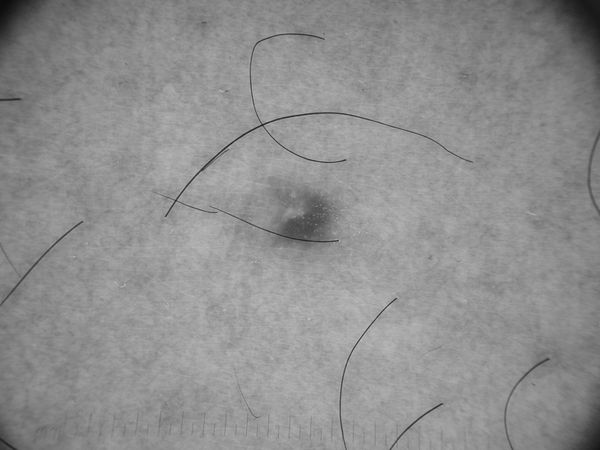

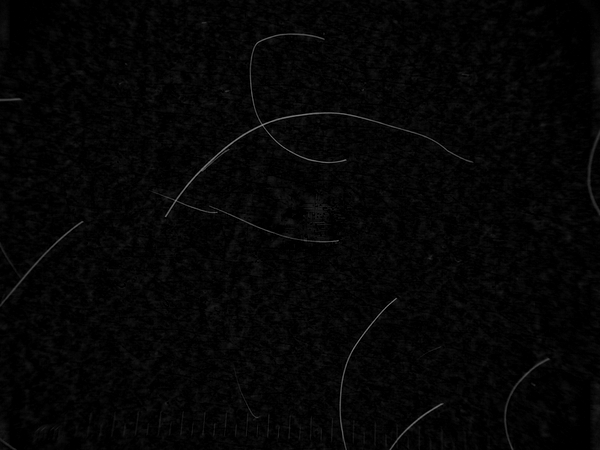

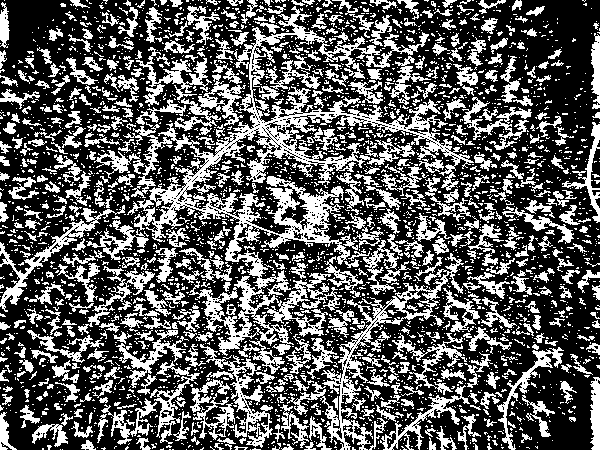

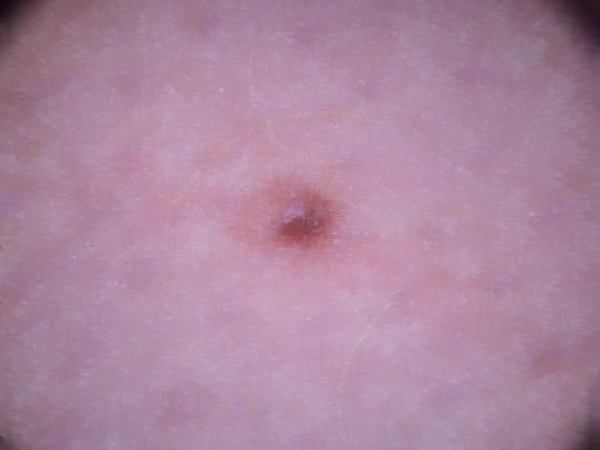

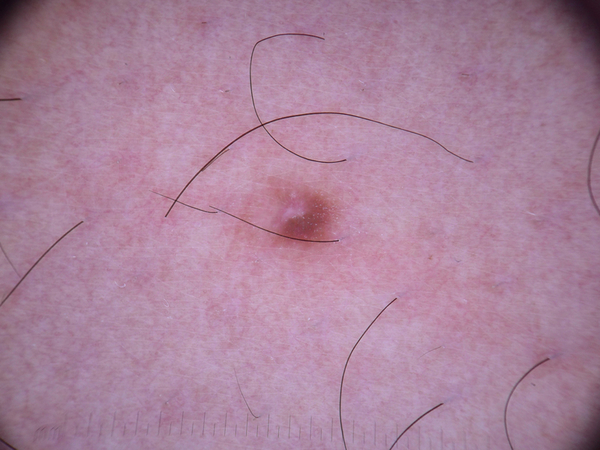

In [ ]:
src = cv2.imread('/content/HAM10000_images/test/df/ISIC_0028735.jpg')


grayScale = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
cv2_imshow(grayScale)


kernel = cv2.getStructuringElement(1,(21,15))


blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
cv2_imshow(blackhat)

ret,thresh2 = cv2.threshold(blackhat,5,255,cv2.THRESH_BINARY)
cv2_imshow(thresh2 )

# Convert src to 8-bit 3-channel format
src_8bit = cv2.convertScaleAbs(src)

# Inpaint the original image depending on the mask
dst = cv2.inpaint(src_8bit, thresh2, 1, cv2.INPAINT_TELEA)

# Display the inpainted image
cv2_imshow(dst)

cv2_imshow(src)

We can see by the different images the transformations mentioned above, that ocurred in order to filter out the hair.

To avoid running times, we have the folder ready below. It has all the same images but with the noise removed. 

In [ ]:
url = 'https://drive.google.com/uc?id=1tQsRxytmTgUW3zV5VjYoOw467-23mZ1H'
output = 'data_transformed.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1tQsRxytmTgUW3zV5VjYoOw467-23mZ1H
To: /content/data_transformed.zip
100%|██████████| 698M/698M [00:02<00:00, 250MB/s]


'data_transformed.zip'

In [ ]:
zip_ = zipfile.ZipFile('data_transformed.zip')
zip_.extractall()
zip_.close()
path = ""

Here we define the paths for our train/test/val folder for the images with the noise reduction.

In [ ]:
training_folder, val_folder, testing_folder = "/content/transformed_data/transformed_train/",\
                           "/content/transformed_data/transformed_val/", "/content/transformed_data/transformed_test/"

In [ ]:
image_size=(128,128) #we are going to use this image size because we need to save a bit more time when the model part comes
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
shuffle=True
seed=0

# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode, 
                                                shuffle=shuffle,
                                                seed=seed)
ds_val = image_dataset_from_directory(val_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)
ds_test = image_dataset_from_directory(testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 6809 files belonging to 7 classes.
Found 1703 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.


Now our ds_train/test/val datasets are composed of the images of our dataset after we filter out the body hair from them.

### 3.2. Oversampling

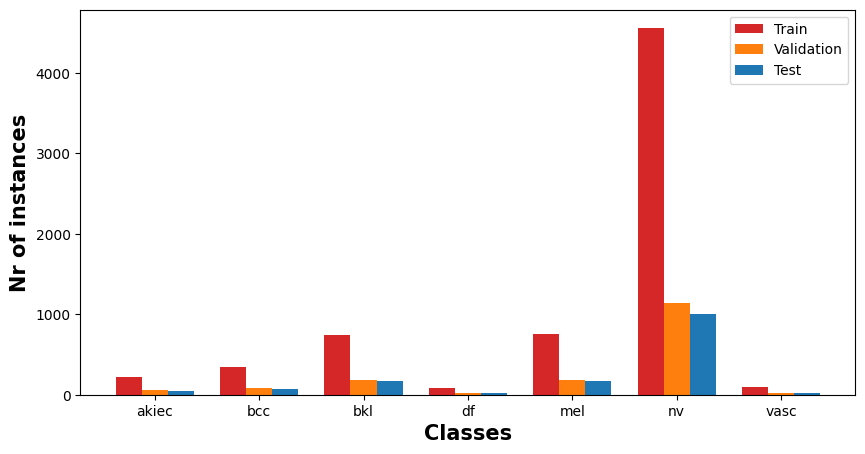

As we saw in the exploration notebook, we have a severe case of unbalanced data. The biggest problem is one class which composes a vast majority of the dataset ("nv"), but inside the minority classes there are also big differences in proportion, because "bkl" and "mel" seem to have double the numver of instances of classes like "akiec" or "bcc". "Df" and "vasc" are the classes which are in a really severe minority.

So, we will make copies of the images to a point where they all have similar numbers of instances. We want to copy all images from each class n times so they have around the same number of instances as the majority class. For this, we'll probably have to undersample the majority class as well. The majority class has 5699 entries, so we will oversample the others to have around 4000, so we do not do too many copies, as we will be contributing to overfitting.

We saw previously that the nr. of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the TRAIN set: [222, 350, 747, 78, 757, 4559, 96]
Below we will see how many copies we need to do to reach about 4000 instances for each class. The number may change, because we will probably try out different sizes of each class, to see if the copies don't just add overfitting to the training images.

In [ ]:
print([round(4000/222,0), round(4000/350,0), round(4000/747,0), round(4000/78,0), round(4000/757,0), round(4000/96,0)])

[18.0, 11.0, 5.0, 51.0, 5.0, 42.0]


Let's define a function to make n copies of each image inside the respective folder and apply it to each train class folder. Note that, to have more control on over and downsampling, we will define the function in the next notebook as well, so it is easier if we need to change the classes' distribution.

In [ ]:
def make_n_copies(folder, n_copies):

# Loop through each file in the images folder
  for image in os.listdir(folder):
    file_path = os.path.join(folder, image)
    # Create n_copies of the file
    for i in range(n_copies):
      new_filename = f"{image.split('.')[0]}_copy{i+1}.jpg"
      new_file_path = os.path.join(folder, new_filename)
      shutil.copy(file_path, new_file_path)

In [ ]:
# Careful, it's inplace, so if we run this two times it will do it two times.
#  If you run it once and run it again by mistake, please restart the runtime 
# (deleting the runtime first so the folders disappear from colab's local storage).
make_n_copies(training_folder + 'akiec', 18)
make_n_copies(training_folder + 'bcc', 11)
make_n_copies(training_folder + 'bkl', 5)
make_n_copies(training_folder + 'df', 51)
make_n_copies(training_folder + 'mel', 5)
make_n_copies(training_folder + 'vasc', 42)

Finally, let's re-do the class distribution analysis, so we can check if it worked and all is more balanced.

Nº of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the TRAIN set: [4218, 4200, 4482, 4056, 4542, 4559, 4128]
Proportion of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the TRAIN set in %: [61.9, 61.7, 65.8, 59.6, 66.7, 66.9, 60.6]

Nº of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the TEST set: [49, 77, 165, 17, 167, 1006, 22]
Proportion of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the TEST set in %: [3.3, 5.1, 11.0, 1.1, 11.1, 66.9, 1.5]

Nº of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the VALIDATION set: [56, 87, 187, 20, 189, 1140, 24]
Proportion of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the VALIDATION set in %: [3.3, 5.1, 11.0, 1.2, 11.1, 66.9, 1.4]



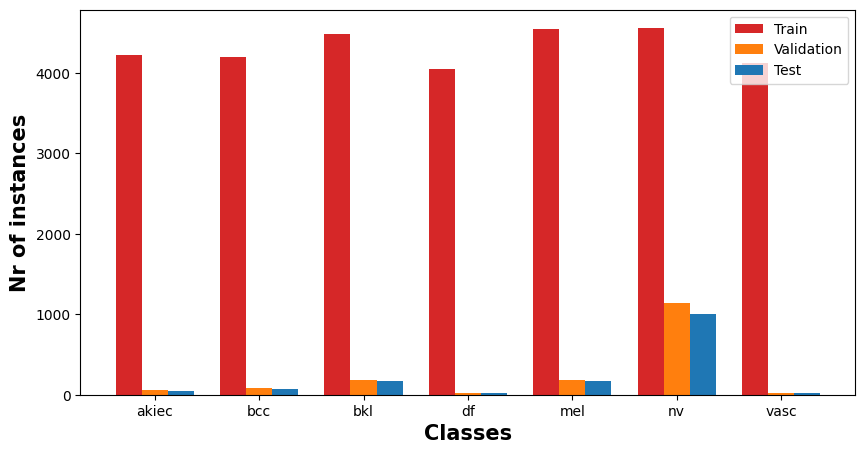

In [ ]:
instances_train = []
instances_val = []
instances_test = []
prop_train = []
prop_val = []
prop_test = []

for split in [training_folder, val_folder, testing_folder]:
    for c in ds_train.class_names:
        n_train_c = len(os.listdir(split + f"/{c}"))

        if split == training_folder:
          total = 6810
          instances_train.append(n_train_c)
          prop_train.append(round(n_train_c*100/total,1))
        elif split == val_folder:
          total = 1703
          instances_val.append(n_train_c)
          prop_val.append(round(n_train_c*100/total,1))
        else:
          total = 1503
          instances_test.append(n_train_c)
          prop_test.append(round(n_train_c*100/total,1))

print(f"Nº of instances in classes {ds_train.class_names} for the TRAIN set: {instances_train}")
print(f"Proportion of instances in classes {ds_train.class_names} for the TRAIN set in %: {prop_train}\n")

print(f"Nº of instances in classes {ds_train.class_names} for the TEST set: {instances_test}")
print(f"Proportion of instances in classes {ds_train.class_names} for the TEST set in %: {prop_test}\n")

print(f"Nº of instances in classes {ds_train.class_names} for the VALIDATION set: {instances_val}")
print(f"Proportion of instances in classes {ds_train.class_names} for the VALIDATION set in %: {prop_val}\n")

barWidth = 0.25
fig = plt.subplots(figsize =(10,5)) 


# Set position of bar on X axis
br1 = np.arange(len(instances_train))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, instances_train, color ='tab:red', width = barWidth, label ='Train')
plt.bar(br2, instances_val, color ='tab:orange', width = barWidth, label ='Validation')
plt.bar(br3, instances_test, color ='tab:blue', width = barWidth,label ='Test')
 
# Adding Xticks
plt.xlabel('Classes', fontweight ='bold', fontsize = 15)
plt.ylabel('Nr of instances', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(instances_train))],
        ds_train.class_names)
 
plt.legend()
plt.show()

As we can see from the chart above, now all the classes have a similiar number of records.

### 3.3. Data Augmentation definition

Legend of what exactly the target names stand for:
- "akiec": actinic keratoses and intraepithelial carcinoma / Bowen's disease
- "bcc": basal cell carcinoma
- "bkl": benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)
- "df": dermatofibroma
- "mel": melanoma
- "nv": melanocytic nevi
- "vasc": vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)


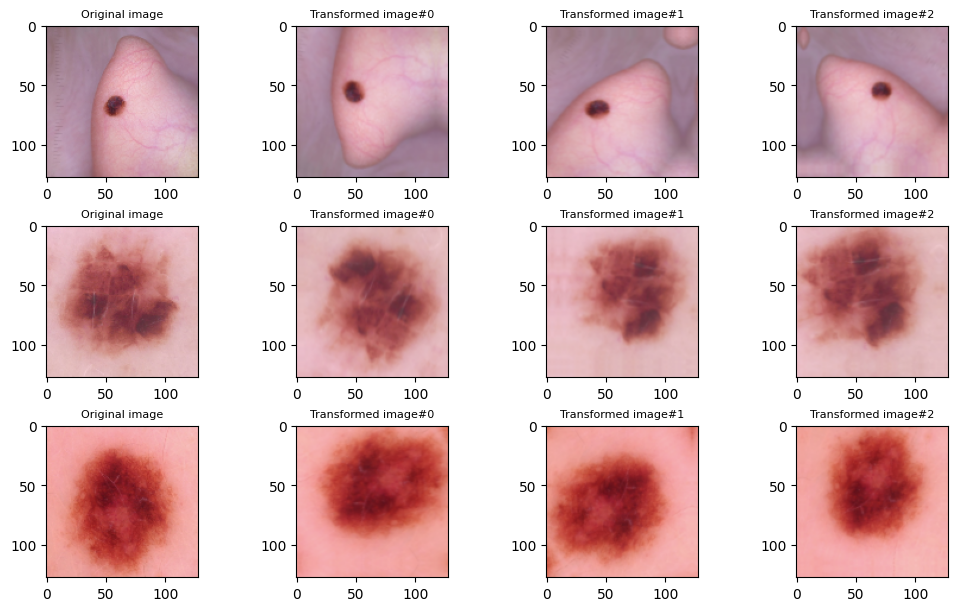

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=3, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.3), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                          #  layers.RandomContrast(factor=0.1),
                          #  layers.RandomBrightness(factor=0.4),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
                           ],
                           name="my_augmentation_pipeline")

show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=augmentation)


We have to be careful, because the transformations have to be enough to change the image, if now we wil create bias in our model as we will be feeding it very similar images, possibly overfitting. Data augmentation will possibly also help with different skin tones and skin characteristics, making a more generalizable algorithm.

However, the data augmentation is done inside the model itself, so we define it in notebook but we will also define it again in the other notebooks, to put inside our model. 